In [1]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [3]:
N_FEATURES = 1
RAND_ST = 42

In [4]:
X, y = make_regression(n_samples=20, n_features=N_FEATURES, noise=10,random_state=RAND_ST)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=RAND_ST)

In [6]:
X_train.shape, y_train.shape

((14, 1), (14,))

In [7]:
X_test.shape, y_test.shape

((6, 1), (6,))

In [8]:
torch.manual_seed(RAND_ST)

In [9]:
class myDataSet(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        point = self.X[idx]
        point = torch.from_numpy(np.asarray(point))
        point = point.to(torch.float32)
        point = torch.reshape(point, (-1,))
        
        label = self.y[idx]
        label = torch.from_numpy(np.asarray(label))
        label = label.to(torch.float32)
        label = torch.reshape(label, (-1,))
        
        return point, label

In [10]:
class MLP(nn.Module):
    def __init__(self, hidden_neurons):
        super().__init__()
        self.n = hidden_neurons
        
        self.linear = nn.Sequential(
            nn.Linear(N_FEATURES, self.n),
            nn.Linear(self.n,1)
        )
        
    def forward(self, x):
        return self.linear(x)


In [11]:
train_dataset = myDataSet(X_train, y_train)
test_dataset = myDataSet(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=1, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=0)

In [12]:
def train_model(neurons):
    loss_fn = nn.MSELoss()
    mlp = MLP(hidden_neurons=neurons)
    mlp = mlp.to(device)
    optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3, weight_decay=1e-5)

    epochs = 10
    for i in range(epochs):
        for data in train_loader:
            x, y = data
            x = x.to(device)
            y = y.to(device)
            y_hat = mlp(x)
            loss = loss_fn(y, y_hat)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    total_test_loss = 0
    with torch.no_grad():
        mlp.eval()
        for data in test_loader:
            inputs, outputs = data
            inputs = inputs.to(device)
            outputs = outputs.to(device)
            predicted_outputs = mlp(inputs)
            loss = loss_fn(predicted_outputs, outputs)
            total_test_loss += loss

    total_test_loss = total_test_loss / len(test_loader)

    return total_test_loss

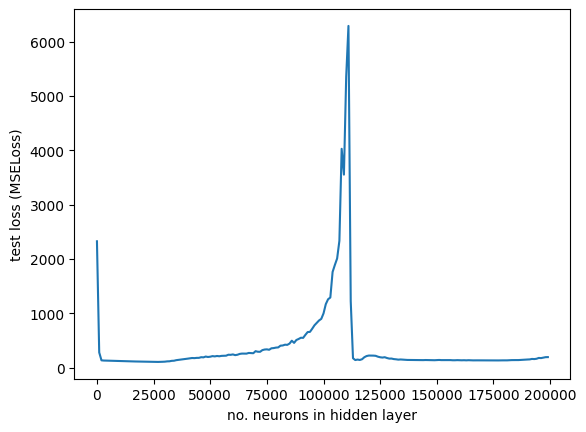

In [13]:
#takes too long to run, keep charged and reduce neurons tested
losses = []
n_neurons = [i for i in range(1, 200000, 1000)]

for n in n_neurons:
    l = train_model(n)
    l = l.detach().cpu().squeeze().numpy()
    losses.append(l)
    
plt.xlabel("no. neurons in hidden layer")
plt.ylabel("test loss (MSELoss)")
plt.plot(n_neurons, losses)
plt.show()